# CD-Projekt RED - Analysis + Data Preparation for RL algorithms (Actor-Critic)

### Importing the necessary libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import os


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
data_path = os.getcwd() + '/data'

### Loading in the data

The data is split in a way, so that I can later evaluate the model performance (train/test split). Train contains the data from August 2013 up to November 2018. Test data is (almost) the whole year 2019 (last date is November 12th 2019)

In [3]:
train = pd.read_csv(data_path + '/cdr_d_train.csv', names = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'],
                   skiprows=1, index_col='Date')
test = pd.read_csv(data_path + '/cdr_d_test.csv', names = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'],
                   skiprows=1, index_col='Date')

In [187]:
test

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,144.71,150.58,141.42,150.28,197959
2019-01-03,150.08,150.08,146.30,147.29,224657
2019-01-04,147.29,150.08,147.29,149.98,164736
2019-01-07,151.28,153.86,150.78,152.97,188888
2019-01-08,153.76,155.95,151.28,152.87,279644
...,...,...,...,...,...
2019-11-05,258.50,259.80,254.00,255.20,213900
2019-11-06,256.00,259.50,253.20,259.50,175238
2019-11-07,259.80,267.90,259.50,267.50,272481


### Plotting, helper functions (classes), EDA

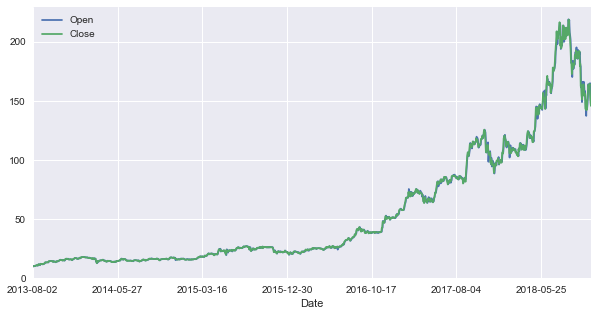

In [7]:
# plt.figure(figsize = (10,5))
train[['Open', 'Close']].plot(kind = 'line', figsize = (10,5))

In [9]:
train.index

Index(['2013-08-02', '2013-08-05', '2013-08-06', '2013-08-07', '2013-08-08',
       '2013-08-09', '2013-08-12', '2013-08-13', '2013-08-14', '2013-08-16',
       ...
       '2018-10-29', '2018-10-30', '2018-10-31', '2018-11-02', '2018-11-05',
       '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09', '2018-11-13'],
      dtype='object', name='Date', length=1319)

In [11]:
class Splitter:
    def __init__(self, split_sign):
        self.split_sign = split_sign
        
    def parser(self, data, months = None, quarters = None):
        container = []
        for elem in range(len(data.index)):
            container.append(data.index[elem].split(self.split_sign))
            
        return container
            
#         if months == True:
#             for element in data.index:
#                 months.append(element[1])
#                 print(months)
        
#         if quarters == True:
#             for element in container:
#                 if element[0][1] in ['01', '02', '03']:
#                     quarters.append('Q1')
#                 elif element[0][1] in ['04', '05', '06']:
#                     quarters.append('Q2')
#                 elif element[0][1] in ['07', '08', '09']:
#                     quarters.append('Q3')
#                 elif element[0][1] in ['10', '11', '12']:
#                     quarters.append('Q4')
                    
#             return quarters

In [12]:
split = Splitter('-')

In [13]:
xs = split.parser(train, months=True)

In [14]:
quarters = []

for i in xs:
    if i[1] in ['01', '02', '03']:
        quarters.append('Q1')
    elif i[1] in ['04', '05', '06']:
        quarters.append('Q2')
    elif i[1] in ['07', '08', '09']:
        quarters.append('Q3')
    elif i[1] in ['10', '11', '12']:
        quarters.append('Q4')

In [29]:
quarters = []
years = []
for i in xs:
    if i[1] in ['01', '02', '03']:
        quarters.append('Q1')
    elif i[1] in ['04', '05', '06']:
        quarters.append('Q2')
    elif i[1] in ['07', '08', '09']:
        quarters.append('Q3')
    elif i[1] in ['10', '11', '12']:
        quarters.append('Q4')
        

for i in xs:
    years.append(i[0])

In [31]:
# train['Quarters'] = quarters
train['Year'] = years 

In [161]:
ratio = train.groupby(['Year', 'Quarters'])['Volume'].transform('max')

In [162]:
train['Vol_ratio'] = train['Volume'] / ratio

In [ ]:
train['Year+Qtr'] = train['Year'] + train['Quarters']

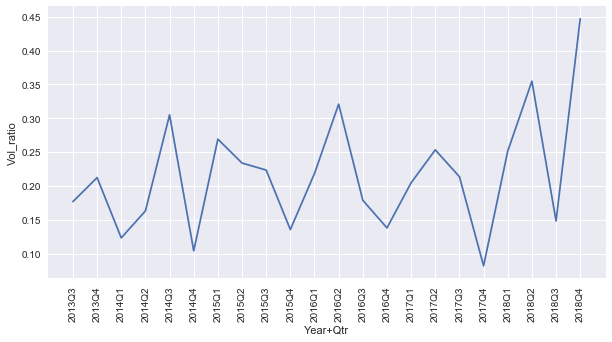

In [169]:
plt.figure(figsize = (10,5))
sns.lineplot(x = 'Year+Qtr', y = 'Vol_ratio', data = train, err_style=None)
plt.xticks(rotation = 90)
plt.show()

So, a short explanation on what I did here. First of all, the plot that shows how the Volume changed on a day-to-day basis tells me absolutely nothing (the data is just noisy). Instead, I opted for a small data science'y "hack" where I "normalize" the variable of interest, to see the actual movement of the 'Volume' on a Year-to-Year, Quarter-to-Quarter basis (in percentage). Each of the observations were "scaled" with the maximum value for a corresponding Quarter, i.e. the data was grouped by, so that I got the "max" value for each quarter, and then every element was divided by that value. What would be interesting to investigate, are the dips in subsequent quarters, first in the 'Q4' of 2014, and then three years later.

Edit: By the same token, I can normalize the other variables in the data set to see interesting patterns and plot them against each other on the same graph (as they are normalized and the "area" sums to 1)

In [178]:
close_ratio = train.groupby(['Year', 'Quarters'])['Close'].transform('max')

In [179]:
train['Close_ratio'] = train['Close'] / close_ratio

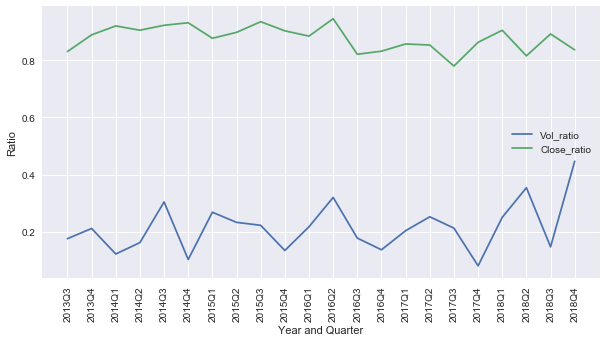

In [185]:
plt.figure(figsize=(10,5))
sns.lineplot(train['Year+Qtr'], train['Vol_ratio'], err_style=None)
sns.lineplot(train['Year+Qtr'], train['Close_ratio'], err_style=None)
plt.xticks(rotation = 90)
plt.legend(['Vol_ratio', 'Close_ratio'], loc = 'best')
plt.xlabel('Year and Quarter')
plt.ylabel('Ratio')
plt.show()

The data for the Warsaw Stock Exchange that I acquired does not contain anything fancy, i.e. there aren't any "Adjusted Open/High/Low/Close/Volume" variables, like in the data for US companies. The last thing that we have to do, before moving on to the actual agent participating in the stock market, is to remove the trend from the data. The initial plot showing the 'Open' and 'Close' prices contains such trend, therefore before feeding the data to the model, we might want to remove it, so that the Agent won't infer anything from it.

### Removing the trend from the data